## Descrição do projeto 

In [27]:
# Importação das bibliotecas

import datetime
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder


## Obtenção dos dados

In [23]:
df = pd.read_csv(r'C:\Users\Jp Lima\Desktop\Use-of-force-classifier\Use-of-force-classifier\data\external\dataset.csv')

**Dicionário de variáveis**

Abaixo temo a descrição dos atributos contidos dentro desse conjunto de dados: 

- `ID` - Número de identificação do uso de força
- `Incident_Num` - Número identificador do incidente de força
- `Incident_Type` - Classificação do uso de força
- `Ocurred_date_time` - Data e hora do ocorrido 
- `Precinct` - Distrito onde ocorreu o uso de força
- `Sector` -  Setor onde ocorreu o uso de força
- `Beat` - 'Batida' onde ocorreu uso da força
- `Officer_ID` - Número identificor do oficial 
- `Subject_ID` - Número identificador do sujeito
- `Subject_Race` - Raça do sujeito do uso de força
- `Subject_Gender` - Gênero do sujeito do uso da força

In [8]:
df.head()

,uniqueid,incident_num,incident_type,occured_date_time,precinct,sector,beat,officer_id,subject_id,subject_race,subject_gender
0,2018UOF-0932-1046-15527,25698,Level 2 - Use of Force,2018-05-05T08:39:00.000,South,SAM,S2,1699,16417,Hispanic or Latino,Male
1,2015UOF-0571-1890-3885,4420,Level 2 - Use of Force,2015-03-28T12:05:00.000,South,SAM,S3,1838,3858,Not Specified,Female
2,2015UOF-0429-157-3928,4489,Level 1 - Use of Force,2015-03-31T00:45:00.000,West,KING,K1,1550,3901,Black or African American,Male
3,2019UOF-0705-1299-11733,45649,Level 1 - Use of Force,2019-06-21T18:41:00.000,West,DAVID,D1,1766,12634,Black or African American,Female
4,2020UOF-0547-1196-22206,55219,Level 2 - Use of Force,2020-04-23T00:57:00.000,West,KING,K3,1623,23089,Black or African American,Male


In [9]:
#Informações gerais do dataset

print('Informações gerais: ')
print('-------'*10)
print(df.info())
print('-------'*10)
print("Tamanho do conjunto de dados")
print(f'{df.shape}')

Informações gerais: 
----------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18157 entries, 0 to 18156
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   uniqueid           18157 non-null  object
 1   incident_num       18157 non-null  int64 
 2   incident_type      18157 non-null  object
 3   occured_date_time  18157 non-null  object
 4   precinct           18157 non-null  object
 5   sector             15809 non-null  object
 6   beat               18157 non-null  object
 7   officer_id         18157 non-null  int64 
 8   subject_id         18157 non-null  int64 
 9   subject_race       18157 non-null  object
 10  subject_gender     18157 non-null  object
dtypes: int64(3), object(8)
memory usage: 1.5+ MB
None
----------------------------------------------------------------------
Tamanho do conjunto de dados
(18157, 11)


In [10]:
#Conversão das datas para o formato datetime

df['occured_date_time'] = pd.to_datetime(df['occured_date_time'])

In [11]:
df.isnull().sum()

uniqueid                0
incident_num            0
incident_type           0
occured_date_time       0
precinct                0
sector               2348
beat                    0
officer_id              0
subject_id              0
subject_race            0
subject_gender          0
dtype: int64

### Tratamento de valores faltantes 

- O tratamento de valores faltantes foi ralizado utilizando o `knn imputer`.

In [28]:
colunas_relevantes = ['incident_type', 'precinct', 'beat', 'subject_race', 'subject_gender', 'sector']
df_relevante = df[colunas_relevantes].copy()

df_relevante['sector'] = df_relevante['sector'].replace('MISSING', np.nan)

In [29]:
label_encoders = {}
for column in df_relevante.columns:
    if df_relevante[column].dtype == 'object':
        le = LabelEncoder()

        valid_values = df_relevante[column][df_relevante[column].notnull()]
        if column == 'sector':
            valid_values = valid_values[valid_values != 'MISSING']
        le.fit(valid_values)
        label_encoders[column] = le

        df_relevante[column] = df_relevante[column].apply(
            lambda x: le.transform([x])[0] if pd.notnull(x) and x != 'MISSING' else np.nan
        )

In [30]:

imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

In [31]:
df_imputed = imputer.fit_transform(df_relevante)

df_imputed = pd.DataFrame(df_imputed, columns=df_relevante.columns)

df_imputed['sector'] = df_imputed['sector'].round().astype(int)

df_imputed['sector'] = label_encoders['sector'].inverse_transform(df_imputed['sector'])

df['sector'] = df_imputed['sector']


In [32]:
print("\nDistribuição de 'sector' após imputação:")
print(df['sector'].value_counts(dropna=False))


Distribuição de 'sector' após imputação:
sector
NORA       2061
EDWARD     1985
KING       1759
GEORGE     1513
DAVID      1232
MARY       1144
ROBERT     1055
SAM        1038
OOJ         896
UNION       804
LINCOLN     714
BOY         659
OCEAN       639
QUEEN       617
FRANK       543
JOHN        502
WILLIAM     501
CHARLIE     495
Name: count, dtype: int64


### Dados Faltantes e Sujos

Durante a etapa de análise exploratória dos dados, percebemos que há problemas com dados faltantes e valores “sujos” em pelo menos 3 das 11 colunas presentes em nosso conjunto de dados. Resumidamente, têm-se:

- `Dados faltantes`: A coluna `sector` apresenta aproximadamente 1593 amostras ausentes. Esse número é um parte significativa dos dados que em análises futuras impactarão significativamente o que se pode fazer com essa coluna. Ou seja, dado sua relevância teremos que tomar medidas relevantes.

- `Valores Incorretos ou “sujos”: As colunas `precinct` e `subject_Gender` foram identificadas com valores “sujos”, que, justamente, referem-se a: “os dados podem conter erros de digitação, não ser bem definidos em suas categorias ou serem inconsistente. Sendo necessário a correção antes de prosseguirmos com as análises”.

### Verificando dados sujos em colunas

In [17]:
for coluna in df.select_dtypes(include="object"):
    print(f"{coluna}: {df[coluna].unique()}")

uniqueid: ['2018UOF-0932-1046-15527' '2015UOF-0571-1890-3885'
 '2015UOF-0429-157-3928' ... '2016UOF-1160-1245-3720'
 '2015UOF-0846-1157-4503' '2022UOF-0026-2283-27020']
incident_type: ['Level 2 - Use of Force' 'Level 1 - Use of Force'
 'Level 3 - Use of Force' 'Level 3 - OIS']
precinct: ['South' 'West' 'Southwest' '-' 'North' 'East' 'OOJ' 'X' '0']
sector: ['SAM' 'KING' 'DAVID' 'FRANK' 'MISSING' 'BOY' 'GEORGE' 'ROBERT' 'MARY'
 'UNION' 'EDWARD' 'QUEEN' 'NORA' 'LINCOLN' 'OOJ' 'JOHN' 'WILLIAM'
 'CHARLIE' 'OCEAN']
beat: ['S2' 'S3' 'K1' 'D1' 'K3' 'F3' '-' 'B2' 'G2' 'R1' 'M1' 'R2' 'U3' 'S1' 'E3'
 'Q1' 'N2' 'M2' 'D2' 'U2' 'L1' '99' 'J1' 'N3' 'N1' 'M3' 'E2' 'G1' 'J3'
 'B1' 'U1' 'E1' 'G3' 'F1' 'W1' 'K2' 'L2' 'D3' 'J2' 'Q3' 'C2' 'O3' 'B3'
 'Q2' 'W3' 'O2' 'R3' 'L3' 'O1' 'F2' 'C3' 'XX' 'W2' 'C1' '0']
subject_race: ['Hispanic or Latino' 'Not Specified' 'Black or African American' 'White'
 'Asian' 'Nat Hawaiian/Oth Pac Islander' 'American Indian/Alaska Native'
 'Two or More Races']
subject_gender: ['

## Visualização de dados 

Neste gáfico buscamos entender de que forma se distribuia os incidentes do uso da força ao longo dos anos, meses.

KeyError: 'Occured_date_time'

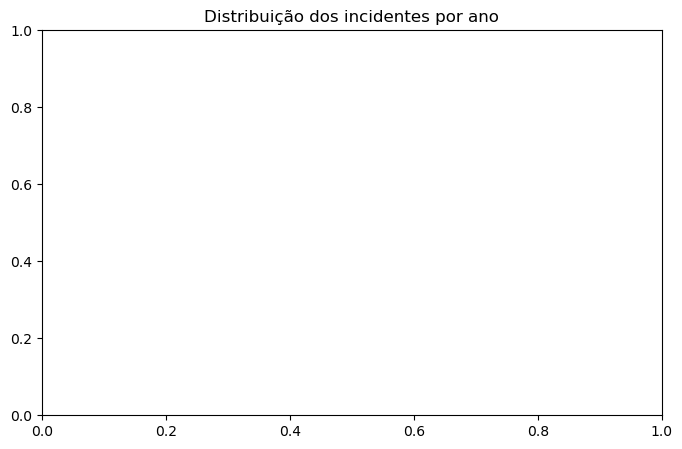

In [18]:

plt.figure(figsize=(8,5))
plt.title('Distribuição dos incidentes por ano')
sns.histplot(df, x=df['Occured_date_time'].dt.year, discrete=True, kde=True);
plt.xlim(2013,2024+1)
plt.show()

c:\Users\joaop\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


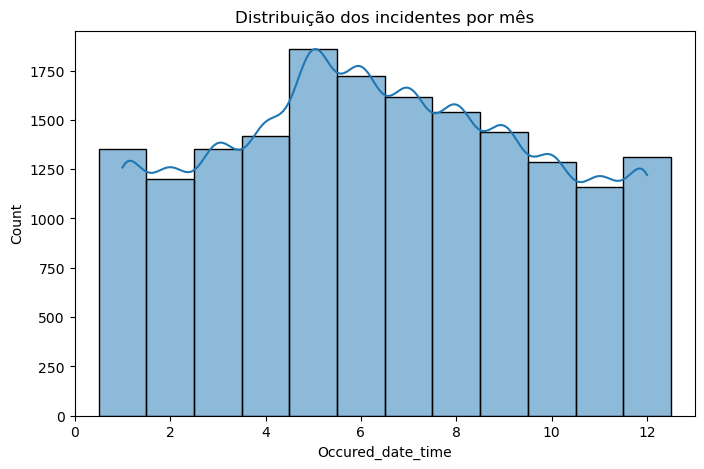

In [ ]:
plt.figure(figsize=(8,5))
plt.title('Distribuição dos incidentes por mês')
sns.histplot(df, x=df['Occured_date_time'].dt.month, kde=True, discrete=True);
plt.xlim(0,12+1)
plt.show()

Buscamos compreender em que regiões da comtém uma maior incidência.

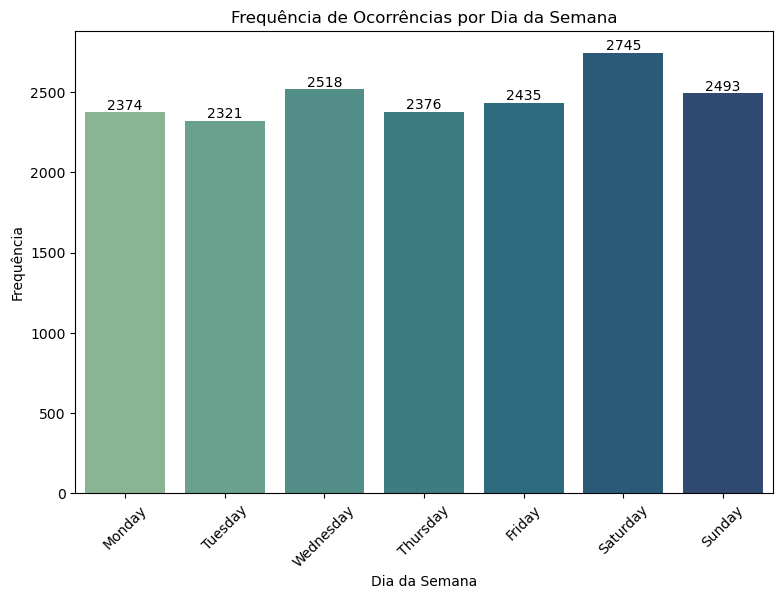

In [ ]:
df['day_of_week'] = df['Occured_date_time'].dt.day_name()

day_counts = df['day_of_week'].value_counts().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], fill_value=0).reset_index()
day_counts.columns = ['day_of_week', 'count']

plt.figure(figsize=(9, 6))
ax =sns.barplot(data=day_counts, x='day_of_week', y='count', palette="crest",estimator="sum", errorbar=None)
ax.bar_label(ax.containers[0], fontsize=10);
plt.title('Frequência de Ocorrências por Dia da Semana')
plt.xlabel('Dia da Semana')
plt.ylabel('Frequência')
plt.xticks(rotation=45)
plt.show()

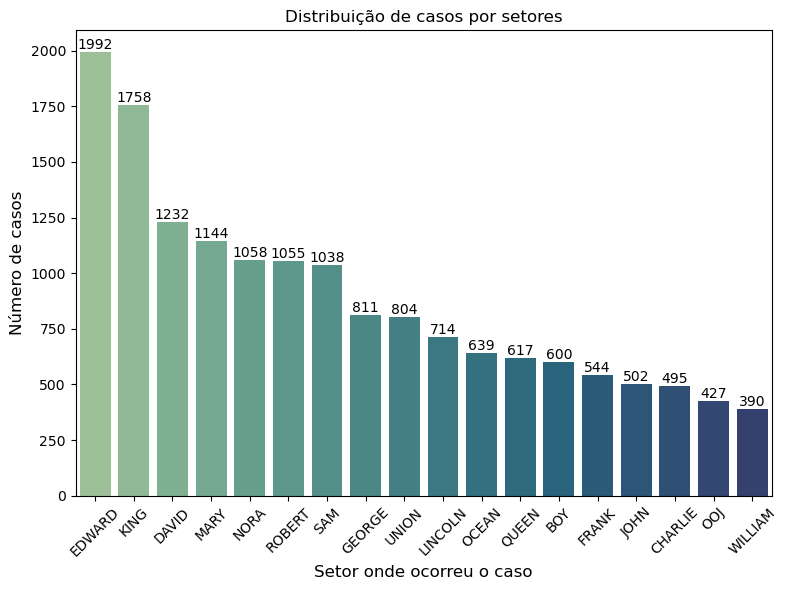

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))

qnt_sector = df['Sector'].value_counts()
qnt_sector = pd.DataFrame(qnt_sector)

plt.xticks(rotation=45)

sns.barplot(x=qnt_sector.index, y=qnt_sector['count'], palette="crest", ax=ax, data=qnt_sector)
ax.bar_label(ax.containers[0], fontsize=10);
ax.set_title("Distribuição de casos por setores")
ax.set_ylabel("Número de casos",fontdict={'fontsize':12})
ax.set_xlabel("Setor onde ocorreu o caso", fontdict={'fontsize':12})


fig.tight_layout();

##### Retirar os dados sujos e faltantes

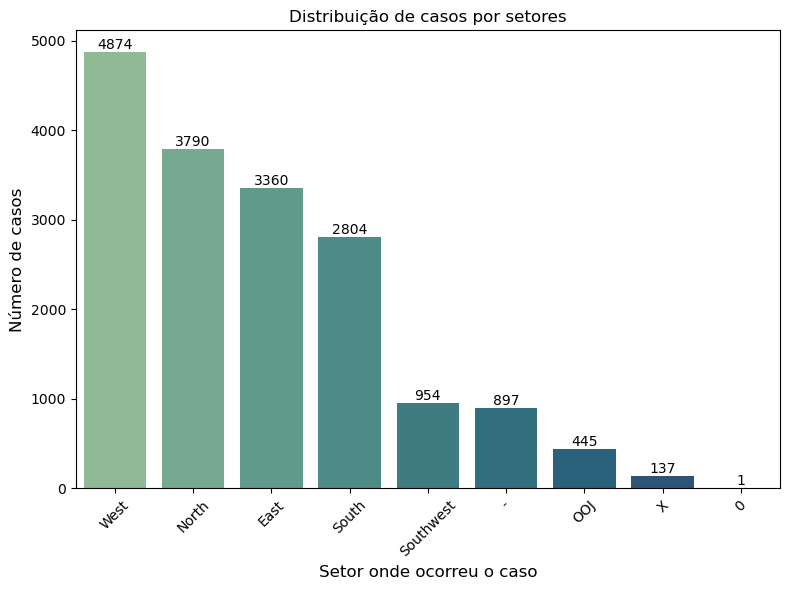

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))

qnt_prec = df['Precinct'].value_counts()
qnt_prec = pd.DataFrame(qnt_prec)

plt.xticks(rotation=45)

sns.barplot(x=qnt_prec.index, y=qnt_prec['count'], palette="crest", ax=ax, data=qnt_prec)
ax.bar_label(ax.containers[0], fontsize=10);
ax.set_title("Distribuição de casos por setores")
ax.set_ylabel("Número de casos",fontdict={'fontsize':12})
ax.set_xlabel("Setor onde ocorreu o caso", fontdict={'fontsize':12})


fig.tight_layout();

In [ ]:
qnt_precinct = df['Precinct'].value_counts()
qnt_precinct

Precinct
West         4874
North        3790
East         3360
South        2804
Southwest     954
-             897
OOJ           445
X             137
0               1
Name: count, dtype: int64

In [ ]:
qnt_precinct.head()

Precinct
West         4874
North        3790
East         3360
South        2804
Southwest     954
Name: count, dtype: int64

## Investigação demográfica

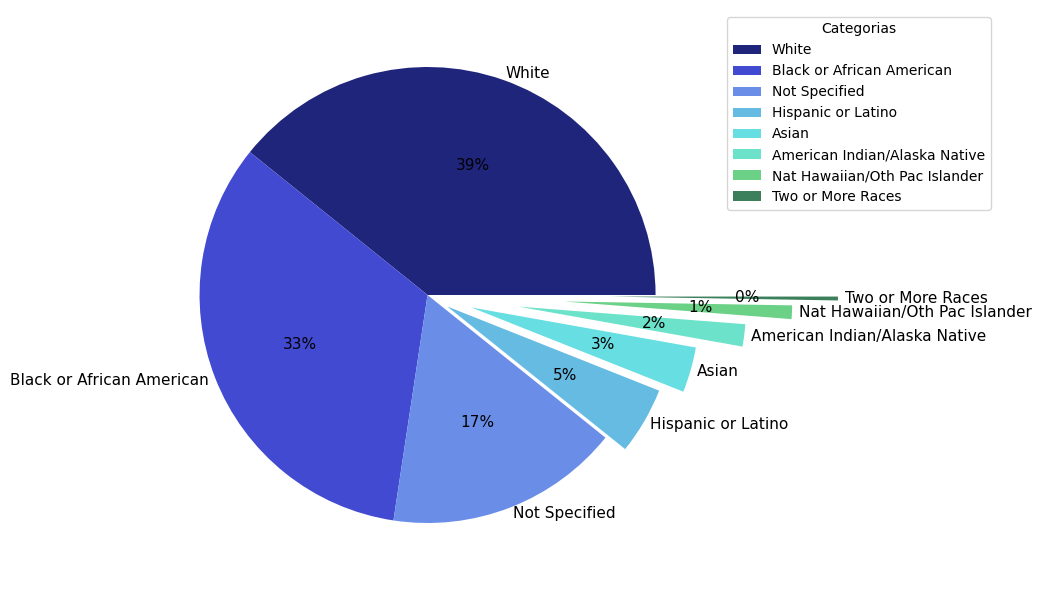

In [ ]:
qnt_race = df['Subject_Race'].value_counts()
plt.figure(figsize=(10,6))

plt.pie(qnt_race.values, labels=qnt_race.index,colors = ["#20257c", 
        "#424ad1", "#6a8ee8", "#66bbe2", "#66dee2", 
        "#6ce2cb", "#6ad187", "#3b7f5b"],
        labeldistance = 1.03, autopct = '%1.0f%%',
        explode = [0, 0, 0, .1, .2, .4, .6, .8], 
        textprops = {"fontsize": 11}, 
        )
plt.legend(qnt_race.index, title="Categorias", bbox_to_anchor=(1.5, 1.0), fontsize=10)
plt.tight_layout()
plt.show()

In [19]:
qnt_gender = df['Subject_Gender'].value_counts()
plt.figure(figsize=(10,6))

plt.pie(qnt_gender.values, labels=qnt_gender.index,colors = ["#20257c", 
        "#424ad1", "#6a8ee8", "#66bbe2", "#66dee2", 
        "#6ce2cb", "#6ad187", "#3b7f5b", "#3b7f5c"],
        labeldistance = 1.03, autopct = '%1.0f%%',
        explode = [ 0, 0, .1, .2, .4, .6, .8, .10], 
        textprops = {"fontsize": 11}, 
        )
plt.legend(qnt_race.index, title="Categorias", bbox_to_anchor=(1.5, 1.0), fontsize=10)
plt.tight_layout()
plt.show()

KeyError: 'Subject_Gender'

In [ ]:
qnt_race = df[''].value_counts()
plt.figure(figsize=(10,6))

plt.pie(qnt_race.values, labels=qnt_race.index,colors = ["#20257c", 
        "#424ad1", "#6a8ee8", "#66bbe2", "#66dee2", 
        "#6ce2cb", "#6ad187", "#3b7f5b"],
        labeldistance = 1.03, autopct = '%1.0f%%',
        explode = [0, 0, 0, .1, .2, .4, .6, .8], 
        textprops = {"fontsize": 11}, 
        )
plt.legend(qnt_race.index, title="Categorias", bbox_to_anchor=(1.5, 1.0), fontsize=10)
plt.tight_layout()
plt.show()